# Assignment 1: 
Cornelis de Jager n8891974
Daniel Brandenburg n8867887
Joel Schwaber n10241337

In [1]:
# Run this if pydot needs to be installed
!pip install pydot

In [2]:
# Imports
import pandas as pd
import numpy as np
import scipy.stats as stats

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

# Import ML libraries
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import VotingClassifier

# Set a random state value
rs = 10

#import libraries to visualize decision trees
import pydot
from io import StringIO


# Ignore Warnings and ignore them
import warnings
warnings.filterwarnings("ignore")

In [3]:
def categoricalPlot(cat, cat2 = 'IsBadBuy'): # Cat is the carigorical as a string i.e 'Size'
    pd.crosstab(data[cat],data[cat2]).plot(kind="bar")
    
def CreateAveragedColumn (A, B):
    C = [np.nan] * len( A )
    for i in range(len(A)):
        C[i] = (A[i] + B[i])/2
    
    return C

def IdentifyOutliers (column):
    data_described = column.describe()
    Q1 = data_described["25%"]
    Q3 = data_described["75%"]
    IQR = Q3-Q1
    lowerLimit = Q1 - 1.5 * IQR
    upperLimit = Q3 + 1.5 * IQR
    output = [np.nan] * len( column )
    for i in range(len(column)):
        value = column[i]
        if value < lowerLimit or value > upperLimit:
            output[i] = True
        else:
            output[i] = False
    return output

def analyse_feature_importance(dm_model, feature_names, n_to_display=5):
    # grab feature importances from the model
    importances = dm_model.feature_importances_
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])
        
# Define a function to find the root node
def getTreeInfo(model, feature_names):
    features  = [feature_names[i] for i in model.tree_.feature]
    print("Root feature is ", features[0])
    print("Competing featues are ", features[1], 'and ', features[2])
    print("Number of nodes is ", model.tree_.node_count)
    
# Write a function that imputes median
def ImputeMean(series):
    return series.fillna(series.mean())

def Normalize (column):
    column =  (column - column.min())/(column.max() - column.min())
    return column

def LogTransform (column):
    column = math.log(column)

In [4]:
def PreProcessing (data):
    print("Pre-Processing Step")
    
    # Check if there are any missing target variables
    if data['IsBadBuy'].isna().any():
        print("Missing Target Variables")
    else:
        print("No missing Target Variables")
    
    
    # Handle Bad Columns drop Columns
    data.drop(['PRIMEUNIT', 'AUCGUART', 'WheelTypeID', 'ForSale', 'PurchaseDate', 'IsOnlineSale'], 
              axis=1, 
              inplace=True)
    

    # Handle Missing Values
    i = 0            # Python's indexing starts at zero
    for item in data['TopThreeAmericanName']:   # Python's for loops are a "for each" loop 
        if data['TopThreeAmericanName'][i] == np.nan and  data['Make'][i] == 'Hyundai':
            data['TopThreeAmericanName'][i] = 'HYUNDAI'
        i += 1
        
    i = 0            # Python's indexing starts at zero
    for item in data['TopThreeAmericanName']:   # Python's for loops are a "for each" loop 
        if data['TopThreeAmericanName'][i] == np.nan and  data['Make'][i] == 'Jeep':
            data['TopThreeAmericanName'][i] = 'JEEP'
        i += 1
        
        
    """ DOES THIS HAVE TO BE THERE """
    # print(data.groupby(['TopThreeAmericanName'])['Make'].value_counts())
    """ DOES THIS HAVE TO BE THERE """
    
    

    # Standardise the capitilization across all object rows
    obj_cols = data.select_dtypes(include='object').columns # Create a list of col names
    for i in obj_cols:              # Interate over the obj_cols list
        data[i] = data[i].str.upper()   # Convert all strings to uppercase  
    # Standardize USA to AMERICA
    data['Nationality'].replace({'USA' : 'AMERICAN'}, inplace = True)
    
    # Turn Transmission into a binary variable with Auto = 1 and Manual = 0
    data.rename({'Transmission' : 'Auto'}, axis = 1, inplace = True)
    # Replace binary columns with 1s and 0s
    data['Auto'].replace({'MANUAL' : 0, 'AUTO' : 1}, inplace=True)
    
    # Remove NOT AVAIL in color and place it in the NaN section
    data['Color'].replace({'NOT AVAIL': np.nan}, inplace = True)
    
    
    """ I'll have to check with teach if this is correct
    #This is the significance test for VNST
    # Check to see if VNST is a statisically significant variable
    # Create a distribution of IsBuyBad for VNST
    VNST_badBuy = pd.crosstab(data['IsBadBuy'], data['VNST']).loc[0]
    VNST_goodBuy = pd.crosstab(data['IsBadBuy'], data['VNST']).loc[1]
    categoricalPlot('VNST')
    
    # Use a Chi2 test to test if there is any corrilation between them, if there is
    # (p < 0.05) discarde the variable
    fScore, pValue = stats.f_oneway(VNST_badBuy, VNST_goodBuy)
    print("The pValaue is " + str(pValue) + " which is significant enough to reject null hypothesis")
    """
    print("Drop VNST due to statistical insignificance")
    data.drop('VNST', axis=1, inplace = True)
    
    # Seperate the Size feature into Size and Body
    tempSize = data['Size'].str.split(' ', expand = True) # Create temp var with split column
    data['Size'] = tempSize[0] # Save the temp var back into data
    data['Body'] = tempSize[1] # Save the temp var back into data
    data['Body'].fillna('CITY', inplace = True) # Assume any other cars are 'City'
    
    
    data.loc[data.Size == 'VAN', 'Body'] = 'Van' # Convert Van into a body type
    data.loc[data.Size == 'VAN', 'Body'] =  np.nan # Take van away from size, shouldn't matter once OH is done
    
    # Converting the TimeStamp into Quater
    Quarter = [] # Create empty string
    for i, _ in enumerate(data.PurchaseTimestamp): # Loop over the entire dataset
        # Convert the epoch datetime into the quater and append to list
        Quarter.append(pd.Timestamp(data.PurchaseTimestamp.loc[i], unit = 's').quarter)        
    data['Quarter'] = Quarter # Create the column with list
    data.drop('PurchaseTimestamp', axis=1, inplace = True) # Drop old TimeStamp
    
    """ This will take care of any Null values we don't specifically take care of
    by replaceing the missing data with data from the same distibution"""
    conv = []
    for i in data.columns: # Loop over dataset
        if data[i].isna().any() == True: # Check to see if there is a NaN is the feature
            dist = data[i].value_counts(normalize=True) # Find the distrabution of the column
            missing = data[i].isna() # Find where the NaN are
            # Replace the NaNs with values from the same distrabution of the column
            data.loc[missing, i] = np.random.choice(dist.index, size=len(data[missing]),p=dist.values)       
            conv.append(i)
            
    print("Converted all of " , conv, "s missing values into the same distrubution")
    
    data['MMRAcquisitionAuctionAveragePrice'] = data['MMRAcquisitionAuctionAveragePrice'].replace(0, np.nan)
    data['MMRAcquisitionAuctionCleanPrice'] = data['MMRAcquisitionAuctionCleanPrice'].replace(0, np.nan)
    data['MMRAcquisitionRetailAveragePrice'] = data['MMRAcquisitionRetailAveragePrice'].replace(0, np.nan)
    data['MMRAcquisitonRetailCleanPrice'] = data['MMRAcquisitonRetailCleanPrice'].replace(0, np.nan)
    data['MMRCurrentAuctionAveragePrice'] = data['MMRCurrentAuctionAveragePrice'].replace(0, np.nan)
    data['MMRCurrentAuctionCleanPrice'] = data['MMRCurrentAuctionCleanPrice'].replace(0, np.nan)
    data['MMRCurrentRetailAveragePrice'] = data['MMRCurrentRetailAveragePrice'].replace(0, np.nan)
    data['MMRCurrentRetailCleanPrice'] = data['MMRCurrentRetailCleanPrice'].replace(0, np.nan)    
    
    # Impute and normalize
    data["MMRAcquisitionAuctionAveragePrice"] = Normalize(ImputeMean(data["MMRAcquisitionAuctionAveragePrice"]))
    data["MMRAcquisitionAuctionCleanPrice"] =  Normalize(ImputeMean(data["MMRAcquisitionAuctionCleanPrice"]))
    data["MMRAcquisitionRetailAveragePrice"] =  Normalize(ImputeMean(data["MMRAcquisitionRetailAveragePrice"]))
    data["MMRAcquisitonRetailCleanPrice"] =  Normalize(ImputeMean(data["MMRAcquisitonRetailCleanPrice"]))
    data["MMRCurrentAuctionAveragePrice"] =  Normalize(ImputeMean(data["MMRCurrentAuctionAveragePrice"]))
    data["MMRCurrentAuctionCleanPrice"] =  Normalize(ImputeMean(data["MMRCurrentAuctionCleanPrice"]))
    data["MMRCurrentRetailAveragePrice"] =  Normalize(ImputeMean(data["MMRCurrentRetailAveragePrice"]))
    data["MMRCurrentRetailCleanPrice"] =  Normalize(ImputeMean(data["MMRCurrentRetailCleanPrice"]))
    
    print(np.corrcoef(data["MMRAcquisitionAuctionAveragePrice"], data["MMRAcquisitionAuctionCleanPrice"]))
    print(np.corrcoef(data["MMRAcquisitionRetailAveragePrice"], data["MMRAcquisitonRetailCleanPrice"]))
    print(np.corrcoef(data["MMRCurrentAuctionAveragePrice"], data["MMRCurrentAuctionCleanPrice"]))
    print(np.corrcoef(data["MMRCurrentRetailAveragePrice"], data["MMRCurrentRetailCleanPrice"])) 
    
    print(data["MMRAcquisitionAuctionAveragePrice"][data["MMRAcquisitionAuctionAveragePrice"] == 0])
    
    """ Create the new columns """
    data["AcquisitionAuctionprice"] = CreateAveragedColumn(data["MMRAcquisitionAuctionAveragePrice"], data["MMRAcquisitionAuctionCleanPrice"])
    data["AcquisitionRetailPrice"] = CreateAveragedColumn(data["MMRAcquisitionRetailAveragePrice"], data["MMRAcquisitonRetailCleanPrice"])
    data["MMRCurrentAuctionPrice"] = CreateAveragedColumn(data["MMRCurrentAuctionAveragePrice"], data["MMRCurrentAuctionCleanPrice"])
    data["MMRCurrentRetailPrice"] = CreateAveragedColumn(data["MMRCurrentRetailAveragePrice"], data["MMRCurrentRetailCleanPrice"])
    
    
        
    
    data.drop('MMRAcquisitionAuctionAveragePrice', inplace = True, axis = 1)
    data.drop('MMRAcquisitionAuctionCleanPrice', inplace = True, axis = 1)
    data.drop('MMRAcquisitonRetailCleanPrice', inplace = True, axis = 1)
    data.drop('MMRCurrentAuctionAveragePrice', inplace = True, axis = 1)
    data.drop('MMRCurrentAuctionCleanPrice', inplace = True, axis = 1)
    data.drop('MMRCurrentRetailAveragePrice', inplace = True, axis = 1)
    data.drop('MMRCurrentRetailCleanPrice', inplace = True, axis = 1)
    data.drop('MMRAcquisitionRetailAveragePrice', inplace = True, axis = 1)
    
    # Do the box plot
    data.boxplot(column=['AcquisitionAuctionprice', 'AcquisitionRetailPrice', 'MMRCurrentAuctionPrice', 'MMRCurrentRetailPrice'], grid = False)
    
    # Now do histograms
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1 =  data["AcquisitionAuctionprice"].hist()
    ax1.grid(False)
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["AcquisitionRetailPrice"].hist()
    ax2.grid(False)
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["MMRCurrentAuctionPrice"].hist()
    ax3.grid(False)
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["MMRCurrentRetailPrice"].hist()
    ax4.grid(False)
    plt.show()

    ## Identify and Remove outiers
    outliers = (IdentifyOutliers(data["AcquisitionAuctionprice"]) and
                IdentifyOutliers(data["AcquisitionRetailPrice"]) and
                IdentifyOutliers(data["MMRCurrentAuctionPrice"]) and
                IdentifyOutliers(data["MMRCurrentRetailPrice"]))
    
    # Select lines that aren't outliers
    num_lines =  len(data["MMRCurrentRetailPrice"])
    data = data[[not i for i in outliers]]
    print ("Lines Removed: ", num_lines - len(data["MMRCurrentRetailPrice"]))
    
    # Do the box plot
    data.boxplot(column=['AcquisitionAuctionprice', 'AcquisitionRetailPrice', 'MMRCurrentAuctionPrice', 'MMRCurrentRetailPrice'], grid = False)
    
    # Now do histograms
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1 =  data["AcquisitionAuctionprice"].hist()
    ax1.grid(False)
    ax2 = fig.add_subplot(2,2,2)
    ax2 =  data["AcquisitionRetailPrice"].hist()
    ax2.grid(False)
    ax3 = fig.add_subplot(2,2,3)
    ax3 =  data["MMRCurrentAuctionPrice"].hist()
    ax3.grid(False)
    ax4 = fig.add_subplot(2,2,4)
    ax4 =  data["MMRCurrentRetailPrice"].hist()
    ax4.grid(False)
    plt.show()
    
    """ This should be the last thing done """
    # Convert all categorical variables into one hot representations
    
    print("The number of features before one hot encoding is " + str(data.shape[1]))
    data_OH = pd.get_dummies(data, columns = ['Auction', 'Make', 'Color', 'VehYear', 
                                              'Nationality', 'Size', 'Body', 'TopThreeAmericanName', 
                                              'WheelType', 'Quarter'])
    print("The number of features after one hot encoding is " + str(data_OH.shape[1]))
    data_OH ["IsBadBuy"] = data['IsBadBuy']
    
    data.describe()
    data.info()
    
    return data, data_OH

Pre-Processing Step
No missing Target Variables
Drop VNST due to statistical insignificance
Converted all of  ['Auction', 'VehYear', 'Make', 'Color', 'Auto', 'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'MMRCurrentRetailRatio', 'VehBCost', 'WarrantyCost', 'Body'] s missing values into the same distrubution
[[1.         0.97926082]
 [0.97926082 1.        ]]
[[1.        0.9860668]
 [0.9860668 1.       ]]
[[1.         0.97740188]
 [0.97740188 1.        ]]
[[1.         0.98202829]
 [0.98202829 1.        ]]
PurchaseID
28625    0.0
Name: MMRAcquisitionAuctionAveragePrice, dtype: float64


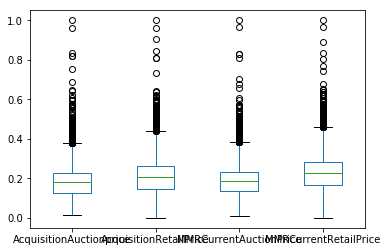

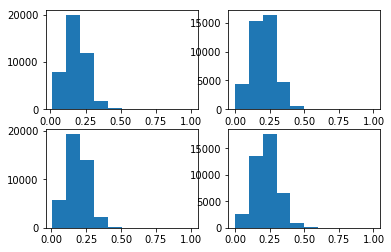

Lines Removed:  223


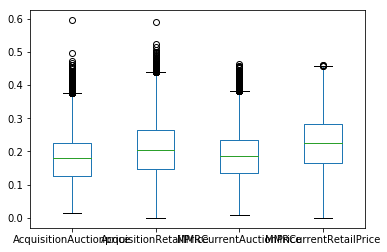

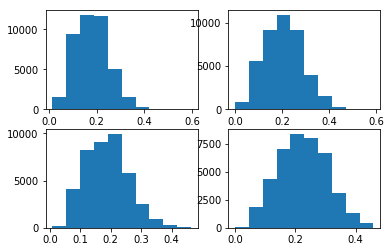

The number of features before one hot encoding is 20
The number of features after one hot encoding is 94
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41253 entries, 0 to 41475
Data columns (total 20 columns):
Auction                    41253 non-null object
VehYear                    41253 non-null float64
Make                       41253 non-null object
Color                      41253 non-null object
Auto                       41253 non-null float64
WheelType                  41253 non-null object
VehOdo                     41253 non-null float64
Nationality                41253 non-null object
Size                       41253 non-null object
TopThreeAmericanName       41253 non-null object
MMRCurrentRetailRatio      41253 non-null float64
VehBCost                   41253 non-null float64
WarrantyCost               41253 non-null float64
IsBadBuy                   41253 non-null int64
Body                       41253 non-null object
Quarter                    41253 non-null int6

In [9]:
data_raw = pd.read_csv("Kick.csv", # Read the csv into a DF
                   index_col = 'PurchaseID', 
                   na_values = ('?',  '#VALUE!'))

data, data_OH = PreProcessing(data_raw) # PreProcess the data

counts = data["IsBadBuy"].value_counts()
total = data["IsBadBuy"].count()
    
# calculate the percentage
# kick is where IsBadBuy == 1
kickPersentage = counts[1] / total * 100
print ("Questin 1.1 :")
print( kickPersentage, "%")

# target/input split
y = data_OH['IsBadBuy']
X = data_OH.drop(['IsBadBuy'], axis=1)

X_mat = X.values # Canvert X into a matrix
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.2, stratify=y, random_state=rs)




<h1>Task 2</h1>

In [23]:
# simple decision tree training
DecisionTreeModel = DecisionTreeClassifier(random_state=rs)
DecisionTreeModel.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

<h2>Task 2.1</h2>
<h3>A: What is the test accuracy?</h3>    

In [55]:
print("Test Model Accuracy:", DecisionTreeModel.score(X_test, y_test))
print("Train Model Accuracy:", DecisionTreeModel.score(X_train, y_train))

Test Model Accuracy: 0.7813598351714943
Train Model Accuracy: 1.0


<h3>B: What is the size of the tree?</h3>  

In [25]:
print("Number of Nodes:", DecisionTreeModel.tree_.node_count)

Number of Nodes: 8681


<h3>C: How many leaves are in the tree that is selected based on the validation data set?</h3>  

In [19]:
print("Answer To be fileld IN")

Answer To be fileld IN


<h3>D: Which variable is used for the first split? What are the competing splits for this first split? </h3> 

In [26]:
getTreeInfo(DecisionTreeModel, feature_names) # Call the root function

Root feature is  AcquisitionAuctionprice
Competing featues are  VehOdo and  VehBCost
Number of nodes is  8681


<h3>E: What are the 5 important variables in building the tree?</h3> 

In [33]:
feature_names = X.columns
analyse_feature_importance(DecisionTreeModel, feature_names, n_to_display=5)

VehOdo : 0.11512027189022053
VehBCost : 0.105572097739474
MMRCurrentRetailRatio : 0.09955074021195237
AcquisitionAuctionprice : 0.09671328822538648
AcquisitionRetailPrice : 0.0891230854833714


<h3>F: Report if you see any evidence of model overfitting</h3> 

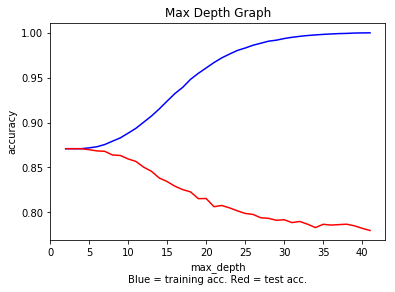

In [84]:
test_score = []
train_score = []

currRange = range(2 , DecisionTreeModel.tree_.max_depth)
# check the model performance for max depth from 2-20
for max_depth in currRange:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rs)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))
    
# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(currRange, train_score, 'b', currRange, test_score, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Max Depth Graph')
plt.show()

<p>As seen from the graph above, the error is low and accuracy is very high at the same depth as the original model, this is a clear sign of overfitting.</p>

<h3>G: Did changing the default setting help improving the model?</h3> 

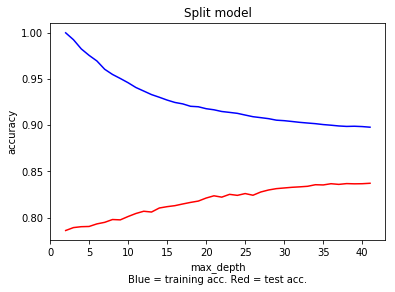

In [53]:
train_score = []
test_score = []

for min_samples_split in currRange:
    model = DecisionTreeClassifier(min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))
    
# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(currRange, train_score, 'b', currRange, test_score, 'r')
plt.xlabel('min_samples_split\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Minimum Split Graphs ')
plt.show()

<p>If we compare the 'Minimum Spit Graph' to that of the 'Max Depth Graph' graph, it becomes clear that forcing additional splits both reduces over fitting and increases accuracy</p>

<h2>Task 2.2</h2>

In [56]:
# grid search CV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 7),
          'min_samples_leaf': range(20, 60, 10)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(2, 7), 'min_samples_leaf': range(20, 60, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

<h3>A: What is the classification accuracy on training and test datasets? </h3>   

In [89]:
print("Test Accuracy:", cv.score(X_test, y_test))
print("Train Accuracy:", cv.score(X_train, y_train))

Test Accuracy: 0.870803538964974
Train Accuracy: 0.8707957093509484


<h3>B: What is the size of tree (i.e. number of nodes)? Is the size different from the maximal tree or the tree in the previous step? Why?</h3>

In [68]:
print("Number of Nodes:", cv.best_estimator_.tree_.node_count)

Number of Nodes: 7


<h3>C: How many leaves are in the tree that is selected based on the validation data set?</h3>  

In [70]:
print("To be filled in")

To be filled in


<h3>D: Which variable is used for the first split? What are the competing splits for this first split? </h3>  

In [74]:
getTreeInfo(cv.best_estimator_, feature_names) # Call the root function

Root feature is  AcquisitionAuctionprice
Competing featues are  VehOdo and  Quarter_3
Number of nodes is  7


<h3>E: What are the 5 important variables in building the tree?</h3>

In [76]:
feature_names = X.columns
analyse_feature_importance(DecisionTreeModel, feature_names, n_to_display=5)

VehOdo : 0.11512027189022053
VehBCost : 0.105572097739474
MMRCurrentRetailRatio : 0.09955074021195237
AcquisitionAuctionprice : 0.09671328822538648
AcquisitionRetailPrice : 0.0891230854833714


<h3>F: Report if you see any evidence of model overfitting</h3> 

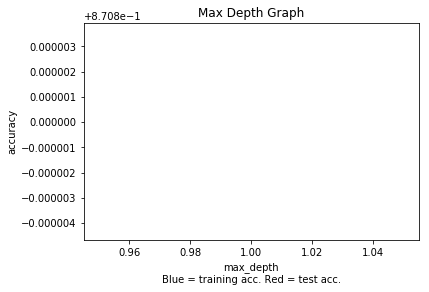

In [81]:
test_score = []
train_score = []

currRange = range(1 , cv.best_estimator_.tree_.max_depth)
# check the model performance for max depth from 2-20
for max_depth in currRange:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rs)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))
    
# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(currRange, train_score, 'b', currRange, test_score, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.title('Max Depth Graph')
plt.show()

<h3>G: What are the parameters used?</h3> 

<h2>Task 3</h2>

In the first model, even especially